In [1]:
import pandas as pd, numpy as np
pd.set_option("max_columns", 50)

from matplotlib import pyplot as plt
#import seaborn as sns
import geopandas as gpd

In [2]:
! ls /home/data/spring_2019/base/

baseline-calibration-smart-rw-52-20.skimsExcerpt.csv
baseline-calibration-smart-rw-55-20.skimsExcerpt.csv
baus_model_data.h5
bay_area_tertiary_strongly_edges.csv
bay_area_tertiary_strongly_nodes.csv
bayarea_walk_edges.csv
bayarea_walk_nodes.csv
buildings_v2.csv
drive_net_vars.csv
establishments_v2.csv
households_v2.csv
jobs_v2.csv
model_data.h5
MTC_craigslist_listings_7-10-18.csv
parcel_attr.csv
persons_v3.csv
run44-30.skimsExcerpt.csv
sfbay-smart-base__2019-03-28_14-22-12
skims_110118.csv
smart-baseline-calibration-rw-55.tar.gz
taz_geoms.csv
Transportation_Analysis_Zones.cpg
Transportation_Analysis_Zones.dbf
Transportation_Analysis_Zones.prj
Transportation_Analysis_Zones.shp
Transportation_Analysis_Zones.shx
Transportation_Analysis_Zones.xml
units_v2.csv
walk_net_vars.csv
zones.csv
zone_shapes.zip


In [4]:
dd = "/home/data/spring_2019/base/"

In [63]:
hh = pd.read_csv("/home/data/spring_2019/base/households_v2.csv", nrows=10**7)

In [62]:
persons = pd.read_csv(dd + "persons_v3.csv", nrows=10**7)

In [2]:
# load in Census tract shapefile
tracts = gpd.read_file("/home/simon/spatial-data/tl_2018_06_tract/tl_2018_06_tract.shp")

# only keep relevant columns
tracts = tracts[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry"]]

# convert ID columns to int to match with UrbanSim data
tracts["COUNTYFP"] = tracts["COUNTYFP"].astype(int)
tracts["TRACTCE"] = tracts["TRACTCE"].astype(int)
tracts["STATEFP"] = tracts["STATEFP"].astype(int)

In [8]:
store = pd.HDFStore("/home/data/spring_2019/outputs/model_data_output.h5")

Opening /home/data/spring_2019/outputs/model_data_output.h5 in read-only mode


In [8]:
store.keys()

['/2010/beam_skims',
 '/2010/buildings',
 '/2010/craigslist',
 '/2010/establishments',
 '/2010/households',
 '/2010/jobs',
 '/2010/parcels',
 '/2010/persons',
 '/2010/skims',
 '/2010/units',
 '/2010/zones',
 '/2015/beam_skims',
 '/2015/buildings',
 '/2015/craigslist',
 '/2015/establishments',
 '/2015/households',
 '/2015/jobs',
 '/2015/parcels',
 '/2015/persons',
 '/2015/skims',
 '/2015/units',
 '/2015/zones',
 '/2025/beam_skims',
 '/2025/buildings',
 '/2025/craigslist',
 '/2025/establishments',
 '/2025/households',
 '/2025/jobs',
 '/2025/parcels',
 '/2025/persons',
 '/2025/skims',
 '/2025/units',
 '/2025/zones']

# Location Quotient

A location quotient provides a way to compare proportions from one smaller geography to a large, containing geography. Thus, the proportion of something needs to be calculated at both of those levels, and those two proportions need to be compared.

Need to:

1. Generate and store percentages for each reference unit.
2. Generate and store percentages for each local unit.
3. Associate reference unit with each local unit.
4. Compare.

In [9]:
yr = 2010

persons = store["/{}/persons".format(yr)]
print("persons:", persons.shape)
hh = store["/{}/households".format(yr)]
print("households:", hh.shape)

('persons:', (6830365, 14))
('households:', (2609004, 21))


In [2]:
def getYearData(year):
    
    persons = store["/{}/persons".format(year)]
    hh = store["/{}/households".format(year)]
    bldg = store["/{}/buildings".format(year)]
    prcl = store["/{}/parcels".format(year)]
    
    
    bldg = bldg.reset_index()[["building_id", "parcel_id"]]
    prcl = prcl.reset_index()[["parcel_id", "county_id"]]
    
    bldg = bldg.merge(prcl, on="parcel_id")
    
    hh = hh.merge(bldg, on="building_id")
    
    hh.index.name = "household_id"
    
    hh = hh.reset_index()
    
    persons.index.name = "person_id"
    persons = persons.reset_index()
    
    
    return persons, hh

In [34]:
subset.head()

,person_id,sex,household_id,tract,county_id
0,1,1,670,601300,85
1,3,1,975,500300,85
2,5,1,2321,201602,55
3,6,1,2785,511609,85
4,7,1,2790,511609,85


In [33]:
subset.groupby(["county_id", "tract"]).agg("count")

person_id  sex  household_id
county_id tract                               
1         10100          14   14            14
          101100          5    5             5
          101200         28   28            28
          10200          20   20            20
          102100         18   18            18
          102202         50   50            50
          102203        155  155           155
          10300          21   21            21
          103100        126  126           126
          103200        121  121           121
          10400           9    9             9
          104101        154  154           154
          104102        154  154           154
          104200         75   75            75
          10500          19   19            19
          105000         36   36            36
          10600          25   25            25
          106001        131  131           131
          106002         78   78            78
          10700          70   70            70
          107000         50   50            50
          10800          21   21            21
          108100         79   79            79
          108200         68   68            68
          10900          40   40            40
          109001         40   40            40
          109002         53   53            53
          11000          59   59            59
          110100         26   26            26
          110200         11   11            11
...                     ...  ...           ...
97        61100          51   51            51
          611000         51   51            51
          611100          5    5             5
          611300         18   18            18
          611600          7    7             7
          611700         31   31            31
          611800          4    4             4
          611900         58   58            58
          61200           7    7             7
          612000          9    9             9
          612100         61   61            61
          612500          4    4             4
          612600         33   33            33
          612700          1    1             1
          612900         28   28            28
          613000         29   29            29
          613200         45   45            45
          613400          3    3             3
          613501         73   73            73
          613502         18   18            18
          613600         22   22            22
          613700        144  144           144
          613800         13   13            13
          613900         18   18            18
          61400          73   73            73
          614000          2    2             2
          61500          50   50            50
          980501         33   33            33
          980600         15   15            15
          981900          3    3             3

[12950 rows x 3 columns]

In [57]:
persons, hh = getYearData(2010)

In [28]:
buildings = store["/2010/buildings"]

In [18]:
store["/2010/parcels"].head()

["county_id"]

,proportion_undevelopable,development_type_id,parcel_id_local,block_id,acres,geom_id,shape_area,apn,tax_exempt_status,county_id,y,x,land_value,imputation_flag,zone_id,node_id
parcel_id,,,,,,,,,,,,,,,,
229116,0.0,1,,060014511022061,3.360520,10305106092872,1.359956e+04,099 029001700,0,1,37.655379,-121.795620,0.0,_,725,22861
244166,0.0,1,,060014511011025,1.294423,11107351665227,5.238348e+03,099B540210200,0,1,37.717277,-121.713004,0.0,_,715,14287
202378,0.0,25,,060014351031029,14.993605,11030175960628,6.067702e+04,085A643106000,1,1,37.655260,-122.014199,6036500.0,merged,820,560
2004420,0.0,-1,,060971541003180,316.247146,6381677629073,1.279808e+06,141-100-012,0,97,38.727893,-122.771868,179954.0,"_, nr_zone_yrblt, bsqft_from_nrsqft, stories1",1401,63607
340332,0.0,2,,060014419272014,0.621275,314875459798,2.514215e+03,525 166004800,0,1,37.546277,-121.974508,0.0,_,763,7502


In [13]:
persons.head()

,student,household_id,age,primary_commute_mode,worker,work_at_home,sex,hours,hispanic,race_id,member_id,edu,relate,earning
1,0,670,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
3,0,975,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
5,0,2321,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
6,0,2785,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
7,0,2790,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0


In [16]:
hh.head()

,base_income_quartile,tenure,age_of_head,block_group_id,serialno,workers,recent_mover,unit_id,base_income_octile,cars,persons,state,block_group,tract,income,hispanic_head,building_type,race_of_head,building_id,single_family,children
1,1,rent,52,60855009011,2013000554587,1.0,0,1711818,2,1.0,1.0,6,1,500901,27000.0,no,9.0,6,1579443,False,0.0
2,1,rent,60,60855009011,2011001140920,1.0,0,1711727,1,1.0,2.0,6,1,500901,6000.0,no,2.0,6,1365639,True,0.0
3,1,rent,51,60855009011,2012001376432,1.0,0,1711548,2,1.0,1.0,6,1,500901,28000.0,yes,3.0,8,647211,True,0.0
4,1,rent,64,60855009011,2013000186929,0.0,0,1711121,1,1.0,1.0,6,1,500901,10000.0,no,6.0,1,309586,False,0.0
5,1,rent,64,60855009011,2013000178279,1.0,0,1711301,2,1.0,1.0,6,1,500901,25600.0,no,4.0,1,409167,False,0.0


In [6]:
results2010 = location_quotient("tract", "county_id", "race_id", "2", out="table", year=2010)

(2010, (6830365, 15))


/home/simon/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:69: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [10]:
results2015 = location_quotient("tract", "county_id", "race_id", "2", out="table", year=2015)

(2015, (7242197, 15))


/home/simon/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:69: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [11]:
results2025 = location_quotient("tract", "county_id", "race_id", "2", out="table", year=2025)

(2025, (7782702, 15))


/home/simon/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:69: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [12]:
! pwd

/home/simon/ual_model_workspace/spring-2019-models/notebooks-simon


In [13]:
results2010.to_csv("LQ_race_id_2010.csv")
results2015.to_csv("LQ_race_id_2015.csv")
results2025.to_csv("LQ_race_id_205.csv")

In [91]:
results.head()

,county_id,tract,1,2,3,4,5,6,7,8,9
0,1,10100,0.894665,0.000000,55.380648,0.0,0.0,0.900073,0.0,0.000000,1.201485
1,1,101100,1.789329,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,1,101200,0.639046,0.000000,0.000000,0.0,0.0,0.300024,0.0,6.663437,1.201485
3,1,10200,1.073597,3.533183,0.000000,0.0,0.0,0.840069,0.0,0.000000,0.000000
4,1,102100,1.093479,0.000000,0.000000,0.0,0.0,0.000000,0.0,5.182673,0.000000


In [85]:
results.columns[-2:]

Index([u'county_id', u'tract'], dtype='object')

In [88]:
results[list(results.columns[-2:])+list(results.columns[:-2].sort_values())]

,county_id,tract,1,2,3,4,5,6,7,8,9
0,1,10100,0.894665,0.000000,55.380648,0.0,0.000000,0.900073,0.000000,0.000000,1.201485
1,1,101100,1.789329,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,101200,0.639046,0.000000,0.000000,0.0,0.000000,0.300024,0.000000,6.663437,1.201485
3,1,10200,1.073597,3.533183,0.000000,0.0,0.000000,0.840069,0.000000,0.000000,0.000000
4,1,102100,1.093479,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,5.182673,0.000000
5,1,102202,1.180957,2.119910,0.000000,0.0,10.616909,0.588048,3.234081,0.533075,0.000000
6,1,102203,1.200582,0.227947,8.336872,0.0,3.424809,0.569079,0.000000,1.203718,0.868170
7,1,10300,0.681649,0.000000,0.000000,0.0,0.000000,1.600130,0.000000,3.173065,0.000000
8,1,103100,1.192886,0.701028,0.000000,0.0,0.000000,0.700057,0.000000,0.846151,1.067987
9,1,103200,1.049937,1.313994,0.000000,0.0,13.161458,0.347136,5.345589,1.982510,0.834089


In [62]:
persons

,person_id,student,household_id,age,primary_commute_mode,worker,work_at_home,sex,hours,hispanic,race_id,member_id,edu,relate,earning
0,1,0,670,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
1,3,0,975,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
2,5,0,2321,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
3,6,0,2785,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
4,7,0,2790,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
5,9,0,2802,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
6,10,0,4092,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
7,11,0,5273,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
8,12,0,5275,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
9,13,0,5279,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0


In [3]:
def location_quotient(unit, ref_unit, variable, category, out, year):
    
    # Step 0 - Subset the data
    
    # subset = persons[["person_id", variable, "household_id"]]\
    #.merge(hh[["household_id", unit, ref_unit]], on="household_id", suffixes=["_p", "_hh"])
    
    persons, hh = getYearData(year)
    
    print(year, persons.shape)
    
    subset = persons[["person_id", variable, "household_id"]]\
    .merge(hh[["household_id", unit, ref_unit]], on="household_id", suffixes=["_p", "_hh"])

    
    # Step 1 - Generate and store percentages for each reference unit.
    
    ## creates a lookup table where the proportions are calculated at the county level.
    ## values can be accessed by indexing in [ref_unit, variable_i] for all i in the variable set (ie. 1 and 2 in sex)
    ref_lookup = pd.crosstab(subset[ref_unit], subset[variable]).apply(lambda r: r/r.sum(), axis=1)
    
    # -----------------------------------------------------------------------------------------------------------
    
    # Step 2 - Generate and store percentages for each local unit
    
    # this DF contains the number of people per unit being analyzed
    unit_totals = subset.groupby([ref_unit,unit,variable]).agg("count")[["person_id"]].groupby(level=[0,1]).agg(sum)
    
    # this DF contains the number of people for each category of the variable being analyzed
    unit_values = subset.groupby([ref_unit,unit,variable]).agg("count")[["person_id"]]
    
    # this DF has both the total number of persons AND the number of persons per category
    compiled = unit_values.reset_index().merge(unit_totals.reset_index(), on=[ref_unit, unit],\
                                               suffixes=["_cat", "_{}".format(unit)])\
    .groupby([ref_unit, unit, variable]).agg("sum")
    
    # create a new column with the percent of persons per that category given the unit
    compiled["pct"] = compiled["person_id_cat"] / compiled["person_id_{}".format(unit)]
    
    # -----------------------------------------------------------------------------------------------------------
    
    # Step 3 - Associate reference unit with local unit
    
    dfs = []

    for i, refDF in compiled.groupby(level=0):
    # i represents the reference geometry unit (e.g. 75 for "county")
    
        for j, localDF  in refDF.groupby(level=1):
            # j represents the local geometry unit (e.g. 40100 for "tract")

            local_values = [i, j]
            cols = [ref_unit, unit]


            for k, valueDF in localDF.groupby(level=2):
                # k represents the variable category (e.g. 1 or 2 for "sex")

                # calculate location quotients by dividing proportion in unit by proportion in ref unit
                try:
                    lq = compiled.loc[i,j,k]["pct"] / ref_lookup.loc[i,k]

                # if there are no records for this particular variable category in this unit, LQ = 0
                except TypeError:

                    lq = 0

                local_values.append(lq)
                cols.append(k)

            dfs.append(pd.DataFrame([local_values], columns=cols))
    results = pd.concat(dfs, ignore_index=True)
    
    # some tracts won't have any values for a certain category. Right now, we'll treat those as 0.
    results.fillna(0, inplace=True)
    
    # reorganize the order of the columns to make intuitive sense if read in table form
    results = results[list(results.columns[-2:])+list(results.columns[:-2].sort_values())]
    
    #return ref_lookup, local_lookup
    if out == "table":
        return results
    elif out == "map":
        
        merged = tracts.merge(xx, left_on=["COUNTYFP", "TRACTCE"], right_on=[ref_unit, unit])
        
        ax = merged.plot(column=2, legend=True, figsize=(20,20))
        ax.set_title("Location Quotient for {} ({}={})".format(variable, variable, category))

In [127]:
# runs of the LQ

xx = location_quotient(unit="tract", ref_unit="county", variable="race_id", out="map", category=1)


/home/simon/anaconda3/envs/template-env/lib/python3.6/site-packages/ipykernel_launcher.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(1577, 11)


In [142]:
persons.columns

Index(['person_id', 'member_id', 'age', 'primary_commute_mode', 'relate',
       'edu', 'sex', 'hours', 'hispanic', 'earning', 'race_id', 'student',
       'work_at_home', 'worker', 'household_id'],
      dtype='object')

/home/simon/anaconda3/envs/template-env/lib/python3.6/site-packages/ipykernel_launcher.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



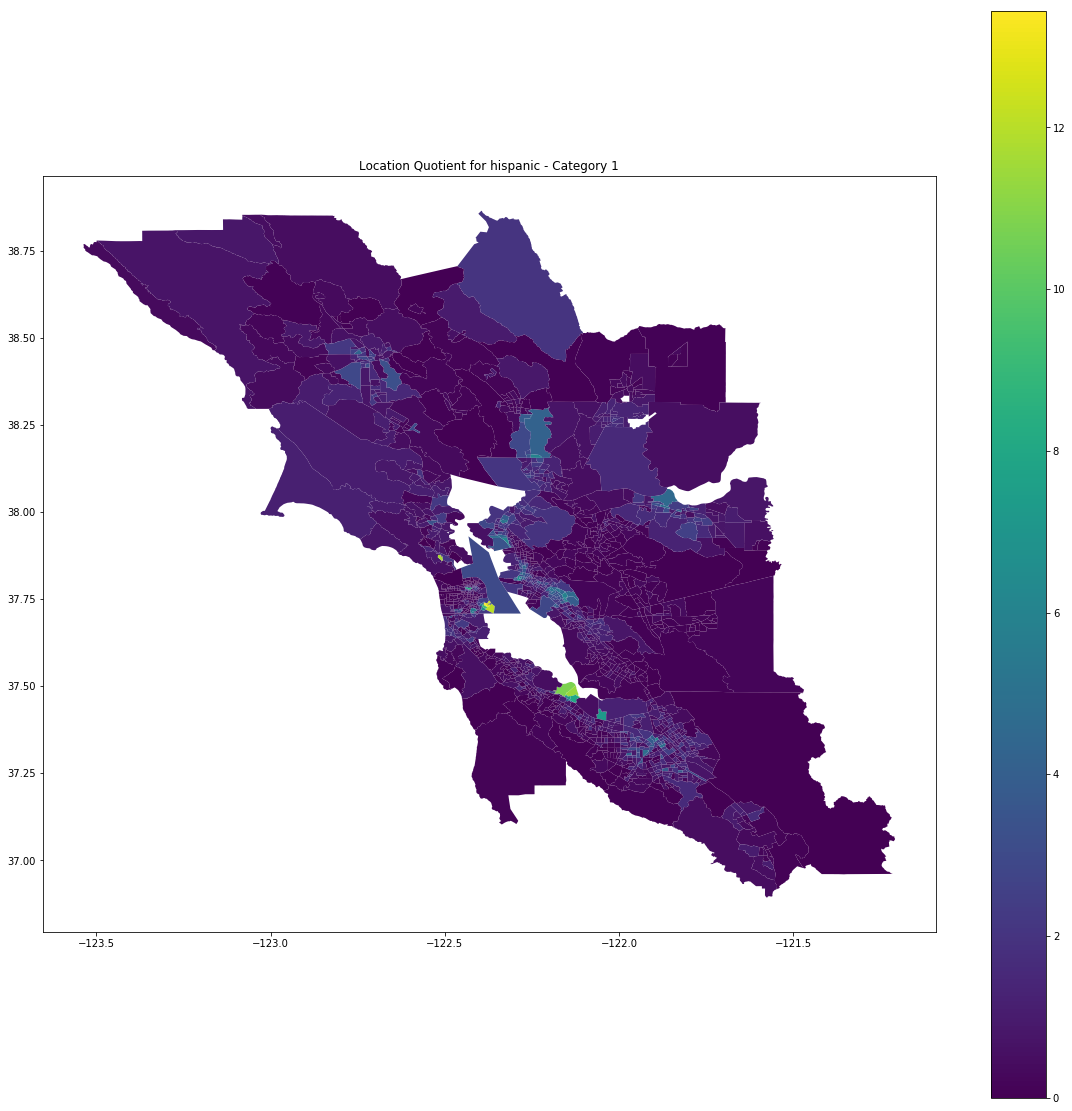

In [143]:
location_quotient(unit="tract", ref_unit="county", variable="hispanic", out="map", category=1)

In [139]:
xx[list(xx.columns[:2])+list(xx.columns[2:].sort_values())]

,county,tract,1,2,3,4,5,6,7,8,9
0,1,400100,1.621607,0.238945,0.382178,0.000000,0.160386,0.597560,0.135616,0.077603,0.971958
1,1,400200,1.851492,0.031755,0.264837,0.000000,0.518663,0.297593,0.073094,0.155003,0.961845
2,1,400300,1.587850,0.970680,0.201545,0.000000,0.888101,0.391916,0.222502,0.154471,0.826745
3,1,400400,1.458928,0.885390,1.632065,0.000000,0.233874,0.575969,0.560305,0.259603,0.762867
4,1,400500,1.291913,2.776525,1.828709,0.000000,0.134302,0.136103,0.492096,0.240817,0.822784
5,1,400600,1.059236,3.043903,2.010769,0.000000,0.590691,0.264093,1.415152,0.361462,1.154100
6,1,400700,0.850922,4.505196,1.429086,0.000000,0.349844,0.053007,0.328683,0.730198,0.930684
7,1,400800,1.005248,3.080516,1.177092,0.000000,0.150342,0.506366,0.550868,0.286695,0.677097
8,1,400900,0.930501,3.324885,2.012612,0.000000,0.875899,0.301865,1.419535,0.635710,1.094971
9,1,401000,0.804467,3.537412,3.533994,0.000000,0.747474,0.115110,1.123619,1.271746,1.606194


In [42]:
xx.drop_duplicates(subset=["county","tract"])["county"].value_counts()

85    15
Name: county, dtype: int64

In [14]:
xx.dtypes

county      int64
tract       int64
1         float64
2         float64
dtype: object

In [130]:
merged = tracts.merge(xx, left_on=["COUNTYFP", "TRACTCE"], right_on=["county", "tract"])

In [56]:
merged.columns

Index([ 'STATEFP', 'COUNTYFP',  'TRACTCE',    'GEOID', 'geometry',   'county',
          'tract',          1,          2,          3,          5,          6,
                7,          8,          9],
      dtype='object')

Text(0.5,1,'Location Quotient for race_id - Category 2')

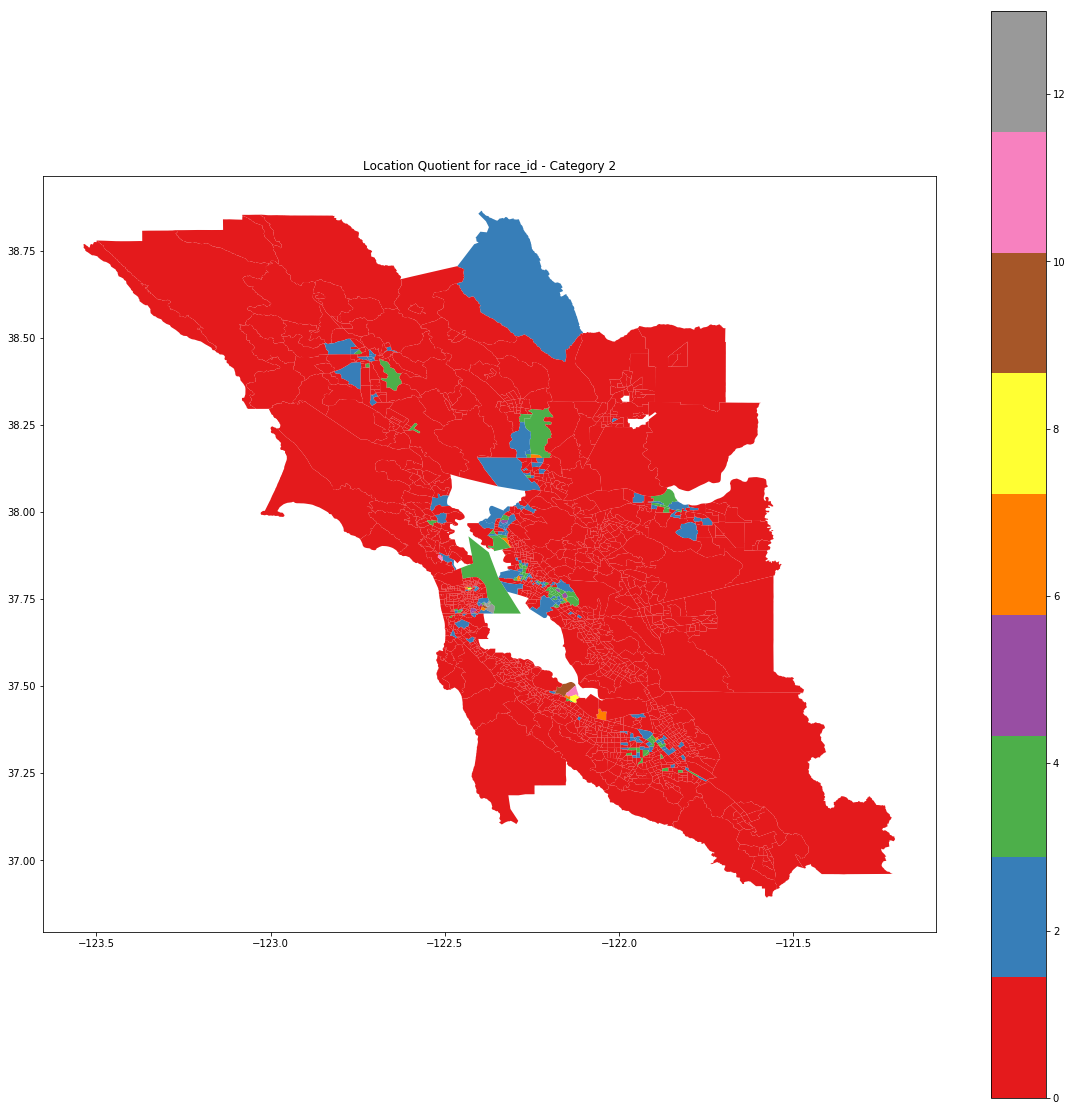

In [157]:
ax = merged2.plot(column=2, legend=True, cmap="Set1", figsize=(20,20))

ax.set_title("Location Quotient for {} - Category {}".format("race_id", 2))

In [151]:
merged2 = merged.copy()

In [154]:
merged2[2] = merged2[2].astype(int)

## De-bugging work below

The following cells contain the function from above, segmented into cells, for de-bugging purposes.

In [9]:
persons, hh = getYearData(2010)

In [11]:
unit, ref_unit, variable = "tract", "county_id", "sex"
    
# Step 0 - Subset the data

subset = persons[["person_id", variable, "household_id"]]\
.merge(hh[["household_id", unit, ref_unit]], on="household_id", suffixes=["_p", "_hh"])

In [68]:
len(persons)

7060806

In [70]:
len(hh)

2677468

In [72]:
subset.head()

,person_id,sex,household_id,tract,county
0,0,1,0,500901,85
1,1,1,670,500300,85
2,2,1,740,500300,85
3,3,1,975,500800,85
4,4,1,977,500800,85


In [12]:
# Step 1 - Generate and store percentages for each reference unit.

## creates a lookup table where the proportions are calculated at the county level.
## values can be accessed by indexing in [ref_unit, variable_i] for all i in the variable set (ie. 1 and 2 in sex)
ref_lookup = pd.crosstab(subset[ref_unit], subset[variable]).apply(lambda r: r/r.sum(), axis=1)

In [13]:
ref_lookup

sex,1,2
county_id,,
1,0.489834,0.510166
13,0.491783,0.508217
41,0.496983,0.503017
55,0.486585,0.513415
75,0.487934,0.512066
81,0.487497,0.512503
85,0.494423,0.505577
95,0.496041,0.503959
97,0.503271,0.496729


In [14]:
unit_totals = subset.groupby([ref_unit,unit,variable]).agg("count")[["person_id"]].groupby(level=[0,1]).agg(sum)

# this DF contains the number of people for each category of the variable being analyzed
unit_values = subset.groupby([ref_unit,unit,variable]).agg("count")[["person_id"]]

# this DF has both the total number of persons AND the number of persons per category
compiled = unit_values.reset_index().merge(unit_totals.reset_index(), on=[ref_unit, unit],\
                                           suffixes=["_cat", "_{}".format(unit)])\
.groupby([ref_unit, unit, variable]).agg("sum")

# create a new column with the percent of persons per that category given the unit
compiled["pct"] = compiled["person_id_cat"] / compiled["person_id_{}".format(unit)]

In [16]:
unit_totals

person_id
county_id tract            
1         10100          14
          101100          5
          101200         28
          10200          20
          102100         18
          102202         50
          102203        155
          10300          21
          103100        126
          103200        121
          10400           9
          104101        154
          104102        154
          104200         75
          10500          19
          105000         36
          10600          25
          106001        131
          106002         78
          10700          70
          107000         50
          10800          21
          108100         79
          108200         68
          10900          40
          109001         40
          109002         53
          11000          59
          110100         26
          110200         11
...                     ...
97        61100          51
          611000         51
          611100          5
          611300         18
          611600          7
          611700         31
          611800          4
          611900         58
          61200           7
          612000          9
          612100         61
          612500          4
          612600         33
          612700          1
          612900         28
          613000         29
          613200         45
          613400          3
          613501         73
          613502         18
          613600         22
          613700        144
          613800         13
          613900         18
          61400          73
          614000          2
          61500          50
          980501         33
          980600         15
          981900          3

[12950 rows x 1 columns]

In [78]:
unit_values.head()

person_id
county tract  sex           
1      400100 1         1406
              2         1498
       400200 1          872
              2          924
       400300 1         2110

In [80]:
compiled.head()

person_id_cat  person_id_tract       pct
county tract  sex                                          
1      400100 1             1406             2904  0.484160
              2             1498             2904  0.515840
       400200 1              872             1796  0.485523
              2              924             1796  0.514477
       400300 1             2110             4720  0.447034

In [91]:
compiled.loc[1, 400100, 1]

person_id_cat      1406.00000
person_id_tract    2904.00000
pct                   0.48416
Name: (1, 400100, 1), dtype: float64

In [88]:
compiled.index.levels[2][:5]

Int64Index([1, 2], dtype='int64', name='sex')

In [93]:
ref_lookup.loc[1, 1]

0.4865412555632608

In [96]:
i,j,k

(75, 10500, 2)

In [103]:
len(compiled.index.levels[0].index.levels[1])

AttributeError: 'Int64Index' object has no attribute 'index'

                   person_id_cat  person_id_tract       pct
county tract  sex                                          
1      400100 1             1406             2904  0.484160
              2             1498             2904  0.515840
       400200 1              872             1796  0.485523
              2              924             1796  0.514477
       400300 1             2110             4720  0.447034
              2             2610             4720  0.552966
       400400 1             1890             3983  0.474517
              2             2093             3983  0.525483
       400500 1             1603             3468  0.462226
              2             1865             3468  0.537774
       400600 1              703             1577  0.445783
              2              874             1577  0.554217
       400700 1             1896             3994  0.474712
              2             2098             3994  0.525288
       400800 1             1406        

In [111]:
m

person_id_cat  person_id_tract       pct
county tract  sex                                          
97     150100 1             1189             2402  0.495004
              2             1213             2402  0.504996
       150202 1             2211             4896  0.451593
              2             2685             4896  0.548407
       150203 1             2379             4819  0.493671
              2             2440             4819  0.506329
       150204 1             1679             3533  0.475234
              2             1854             3533  0.524766
       150303 1             2169             4359  0.497591
              2             2190             4359  0.502409
       150304 1             2845             5736  0.495990
              2             2891             5736  0.504010
       150305 1             2860             5614  0.509441
              2             2754             5614  0.490559
       150306 1             1930             3828  0.504180
              2             1898             3828  0.495820
       150500 1             2207             4654  0.474216
              2             2447             4654  0.525784
       150601 1             2081             4410  0.471882
              2             2329             4410  0.528118
       150602 1             1970             3914  0.503321
              2             1944             3914  0.496679
       150603 1             3051             6306  0.483825
              2             3255             6306  0.516175
       150607 1             2517             5156  0.488169
              2             2639             5156  0.511831
       150609 1             2097             4487  0.467350
              2             2390             4487  0.532650
       150610 1             1999             3885  0.514543
              2             1886             3885  0.485457
...                          ...              ...       ...
       153804 1             1520             3171  0.479344
              2             1651             3171  0.520656
       153806 1             1534             3195  0.480125
              2             1661             3195  0.519875
       153807 1             1866             3771  0.494829
              2             1905             3771  0.505171
       153808 1             1965             4023  0.488441
              2             2058             4023  0.511559
       153809 1             2101             4234  0.496221
              2             2133             4234  0.503779
       153901 1             2150             4488  0.479055
              2             2338             4488  0.520945
       153902 1             1997             4148  0.481437
              2             2151             4148  0.518563
       153903 1             1915             4008  0.477794
              2             2093             4008  0.522206
       154000 1             1277             2439  0.523575
              2             1162             2439  0.476425
       154100 1             1766             3447  0.512330
              2             1681             3447  0.487670
       154201 1             1587             3372  0.470641
              2             1785             3372  0.529359
       154202 1             2692             5715  0.471041
              2             3023             5715  0.528959
       154302 1             1471             3132  0.469668
              2             1661             3132  0.530332
       154303 1              595             1338  0.444694
              2              743             1338  0.555306
       154304 1              869             1926  0.451194
              2             1057             1926  0.548806

[198 rows x 3 columns]

In [ ]:
for l, m in compiled.groupby(level=0):
    print(m)

In [115]:
refDF.groupby(level=1)

ValueError: too many values to unpack (expected 2)

In [119]:
dfs = []

for i, refDF in compiled.groupby(level=0):
    # i represents the reference geometry unit (e.g. 75 for "county")
    
    for j, localDF  in refDF.groupby(level=1):
        # j represents the local geometry unit (e.g. 40100 for "tract")
        
        local_values = [i, j]
        cols = [ref_unit, unit]
        
        
        for k, valueDF in localDF.groupby(level=2):
            # k represents the variable category (e.g. 1 or 2 for "sex")

            # calculate location quotients by dividing proportion in unit by proportion in ref unit
            try:
                lq = compiled.loc[i,j,k]["pct"] / ref_lookup.loc[i,k]

            # if there are no records for this particular variable category in this unit, LQ = 0
            except TypeError:
            
                lq = 0

            local_values.append(lq)
            cols.append(k)

        dfs.append(pd.DataFrame([local_values], columns=cols))

0.48415977961432505
0.48415977961432505 0.4865412555632608
0.5158402203856749
0.5158402203856749 0.5134587444367392
0.48552338530066813
0.48552338530066813 0.4865412555632608
0.5144766146993318
0.5144766146993318 0.5134587444367392
0.4470338983050847
0.4470338983050847 0.4865412555632608
0.5529661016949152
0.5529661016949152 0.5134587444367392
0.47451669595782076
0.47451669595782076 0.4865412555632608
0.5254833040421792
0.5254833040421792 0.5134587444367392
0.4622260668973472
0.4622260668973472 0.4865412555632608
0.5377739331026529
0.5377739331026529 0.5134587444367392
0.4457831325301205
0.4457831325301205 0.4865412555632608
0.5542168674698795
0.5542168674698795 0.5134587444367392
0.4747120681021532
0.4747120681021532 0.4865412555632608
0.5252879318978467
0.5252879318978467 0.5134587444367392
0.4538411878631375
0.4538411878631375 0.4865412555632608
0.5461588121368625
0.5461588121368625 0.5134587444367392
0.4715561824165491
0.4715561824165491 0.4865412555632608
0.5284438175834508
0.5284

0.49817557415754454
0.49817557415754454 0.4865412555632608
0.5018244258424555
0.5018244258424555 0.5134587444367392
0.5118577075098815
0.5118577075098815 0.4865412555632608
0.4881422924901186
0.4881422924901186 0.5134587444367392
0.4877734877734878
0.4877734877734878 0.4865412555632608
0.5122265122265123
0.5122265122265123 0.5134587444367392
0.49154356668807536
0.49154356668807536 0.4865412555632608
0.5084564333119247
0.5084564333119247 0.5134587444367392
0.4903391167192429
0.4903391167192429 0.4865412555632608
0.5096608832807571
0.5096608832807571 0.5134587444367392
0.4669464847848898
0.4669464847848898 0.4865412555632608
0.5330535152151101
0.5330535152151101 0.5134587444367392
0.4638759689922481
0.4638759689922481 0.4865412555632608
0.536124031007752
0.536124031007752 0.5134587444367392
0.4526280549045865
0.4526280549045865 0.4865412555632608
0.5473719450954134
0.5473719450954134 0.5134587444367392
0.4642576590730558
0.4642576590730558 0.4865412555632608
0.5357423409269442
0.53574234

0.5040194428865209
0.5040194428865209 0.4865412555632608
0.49598055711347916
0.49598055711347916 0.5134587444367392
0.4907536636427076
0.4907536636427076 0.4865412555632608
0.5092463363572924
0.5092463363572924 0.5134587444367392
0.5026894865525673
0.5026894865525673 0.4865412555632608
0.49731051344743277
0.49731051344743277 0.5134587444367392
0.49453551912568305
0.49453551912568305 0.4865412555632608
0.505464480874317
0.505464480874317 0.5134587444367392
0.4604588995321898
0.4604588995321898 0.4865412555632608
0.5395411004678102
0.5395411004678102 0.5134587444367392
0.49396759738021373
0.49396759738021373 0.4865412555632608
0.5060324026197863
0.5060324026197863 0.5134587444367392
0.4742647058823529
0.4742647058823529 0.4865412555632608
0.5257352941176471
0.5257352941176471 0.5134587444367392
0.48252265581653414
0.48252265581653414 0.4865412555632608
0.5174773441834659
0.5174773441834659 0.5134587444367392
0.4805124011992368
0.4805124011992368 0.4865412555632608
0.5194875988007631
0.51

0.48927462602314425
0.48927462602314425 0.4865412555632608
0.5107253739768558
0.5107253739768558 0.5134587444367392
0.511653234589414
0.511653234589414 0.4865412555632608
0.4883467654105859
0.4883467654105859 0.5134587444367392
0.4724308481406851
0.4724308481406851 0.4865412555632608
0.5275691518593149
0.5275691518593149 0.5134587444367392
0.5039745627980922
0.5039745627980922 0.4865412555632608
0.4960254372019078
0.4960254372019078 0.5134587444367392
0.4878765613519471
0.4878765613519471 0.4865412555632608
0.5121234386480529
0.5121234386480529 0.5134587444367392
0.5049273858921162
0.5049273858921162 0.4865412555632608
0.49507261410788383
0.49507261410788383 0.5134587444367392
0.4862884655641616
0.4862884655641616 0.4865412555632608
0.5137115344358384
0.5137115344358384 0.5134587444367392
0.4979146615335258
0.4979146615335258 0.4865412555632608
0.5020853384664742
0.5020853384664742 0.5134587444367392
0.4906764168190128
0.4906764168190128 0.4865412555632608
0.5093235831809872
0.50932358

0.5039612676056338
0.5039612676056338 0.4878300076654621
0.4960387323943662
0.4960387323943662 0.5121699923345379
0.5100526567735759
0.5100526567735759 0.4878300076654621
0.48994734322642414
0.48994734322642414 0.5121699923345379
0.45326817348808796
0.45326817348808796 0.4878300076654621
0.546731826511912
0.546731826511912 0.5121699923345379
0.4651522973670625
0.4651522973670625 0.4878300076654621
0.5348477026329376
0.5348477026329376 0.5121699923345379
0.4748415213946117
0.4748415213946117 0.4878300076654621
0.5251584786053882
0.5251584786053882 0.5121699923345379
0.4417206290471785
0.4417206290471785 0.4878300076654621
0.5582793709528214
0.5582793709528214 0.5121699923345379
0.4699281867145422
0.4699281867145422 0.4878300076654621
0.5300718132854578
0.5300718132854578 0.5121699923345379
0.4780623890438752
0.4780623890438752 0.4878300076654621
0.5219376109561248
0.5219376109561248 0.5121699923345379
0.4772785954040795
0.4772785954040795 0.4878300076654621
0.5227214045959204
0.52272140

0.4912420382165605
0.4912420382165605 0.4878300076654621
0.5087579617834395
0.5087579617834395 0.5121699923345379
0.5001026904908605
0.5001026904908605 0.4878300076654621
0.49989730950913946
0.49989730950913946 0.5121699923345379
0.4947725851130373
0.4947725851130373 0.4878300076654621
0.5052274148869628
0.5052274148869628 0.5121699923345379
0.49552772808586765
0.49552772808586765 0.4878300076654621
0.5044722719141324
0.5044722719141324 0.5121699923345379
0.5078634445723054
0.5078634445723054 0.4878300076654621
0.4921365554276947
0.4921365554276947 0.5121699923345379
0.5142508143322475
0.5142508143322475 0.4878300076654621
0.48574918566775244
0.48574918566775244 0.5121699923345379
0.499609505745844
0.499609505745844 0.4878300076654621
0.5003904942541559
0.5003904942541559 0.5121699923345379
0.5059607742597103
0.5059607742597103 0.4878300076654621
0.4940392257402897
0.4940392257402897 0.5121699923345379
0.5102222222222222
0.5102222222222222 0.4878300076654621
0.48977777777777776
0.48977

0.47143740977521137
0.47143740977521137 0.4763164836614238
0.5285625902247886
0.5285625902247886 0.5236835163385762
0.39067524115755625
0.39067524115755625 0.4763164836614238
0.6093247588424437
0.6093247588424437 0.5236835163385762
0.4787825577992391
0.4787825577992391 0.4763164836614238
0.5212174422007609
0.5212174422007609 0.5236835163385762
0.46446175862617267
0.46446175862617267 0.4763164836614238
0.5355382413738273
0.5355382413738273 0.5236835163385762
0.4532077692760447
0.4532077692760447 0.4763164836614238
0.5467922307239552
0.5467922307239552 0.5236835163385762
0.4653587840226228
0.4653587840226228 0.4763164836614238
0.5346412159773771
0.5346412159773771 0.5236835163385762
0.4585196224540487
0.4585196224540487 0.4763164836614238
0.5414803775459514
0.5414803775459514 0.5236835163385762
0.48889704532941824
0.48889704532941824 0.4763164836614238
0.5111029546705818
0.5111029546705818 0.5236835163385762
0.4632176005500172
0.4632176005500172 0.4763164836614238
0.5367823994499828
0.53

0.5683168316831683
0.5683168316831683 0.5109472385303802
0.4316831683168317
0.4316831683168317 0.4890527614696198
0.4997255762897914
0.4997255762897914 0.5109472385303802
0.5002744237102086
0.5002744237102086 0.4890527614696198
0.5776555793991416
0.5776555793991416 0.5109472385303802
0.42234442060085836
0.42234442060085836 0.4890527614696198
0.5934065934065934
0.5934065934065934 0.5109472385303802
0.4065934065934066
0.4065934065934066 0.4890527614696198
0.38263665594855306
0.38263665594855306 0.5109472385303802
0.617363344051447
0.617363344051447 0.4890527614696198
0.5705463182897862
0.5705463182897862 0.5109472385303802
0.42945368171021375
0.42945368171021375 0.4890527614696198
0.5381558028616852
0.5381558028616852 0.5109472385303802
0.46184419713831476
0.46184419713831476 0.4890527614696198
0.6281879194630873
0.6281879194630873 0.5109472385303802
0.3718120805369127
0.3718120805369127 0.4890527614696198
0.5730032526201663
0.5730032526201663 0.5109472385303802
0.42699674737983373
0.426

0.49992699664184553 0.5109472385303802
0.5000730033581545
0.5000730033581545 0.4890527614696198
0.5129416210088796
0.5129416210088796 0.5109472385303802
0.48705837899112037
0.48705837899112037 0.4890527614696198
0.4762264150943396
0.4762264150943396 0.5109472385303802
0.5237735849056604
0.5237735849056604 0.4890527614696198
0.48773773773773776
0.48773773773773776 0.5109472385303802
0.5122622622622622
0.5122622622622622 0.4890527614696198
0.4752288637587507
0.4752288637587507 0.5109472385303802
0.5247711362412494
0.5247711362412494 0.4890527614696198
0.4970513900589722
0.4970513900589722 0.5109472385303802
0.5029486099410277
0.5029486099410277 0.4890527614696198
0.500082467425367
0.500082467425367 0.5109472385303802
0.499917532574633
0.499917532574633 0.4890527614696198
0.4954490291262136
0.4954490291262136 0.5109472385303802
0.5045509708737864
0.5045509708737864 0.4890527614696198
0.5228513940787582
0.5228513940787582 0.5109472385303802
0.47714860592124175
0.47714860592124175 0.4890527

0.5105513955071477
0.5105513955071477 0.5091708457384788
0.5009846396218984
0.5009846396218984 0.49082915426152124
0.4990153603781016
0.4990153603781016 0.5091708457384788
0.4838444687842278
0.4838444687842278 0.49082915426152124
0.5161555312157722
0.5161555312157722 0.5091708457384788
0.48137776533183985
0.48137776533183985 0.49082915426152124
0.5186222346681602
0.5186222346681602 0.5091708457384788
0.5028280542986425
0.5028280542986425 0.49082915426152124
0.4971719457013575
0.4971719457013575 0.5091708457384788
0.49544724156400644
0.49544724156400644 0.49082915426152124
0.5045527584359936
0.5045527584359936 0.5091708457384788
0.5146862483311081
0.5146862483311081 0.49082915426152124
0.48531375166889185
0.48531375166889185 0.5091708457384788
0.4591269841269841
0.4591269841269841 0.49082915426152124
0.5408730158730158
0.5408730158730158 0.5091708457384788
0.5114186851211072
0.5114186851211072 0.49082915426152124
0.4885813148788927
0.4885813148788927 0.5091708457384788
0.501049475262368

0.48278958395689914
0.48278958395689914 0.49915015714971145
0.5172104160431009
0.5172104160431009 0.5008498428502886
0.5009924573243351
0.5009924573243351 0.49915015714971145
0.49900754267566494
0.49900754267566494 0.5008498428502886
0.47999369880277254
0.47999369880277254 0.49915015714971145
0.5200063011972275
0.5200063011972275 0.5008498428502886
0.48952095808383234
0.48952095808383234 0.49915015714971145
0.5104790419161677
0.5104790419161677 0.5008498428502886
0.48954116059379216
0.48954116059379216 0.49915015714971145
0.5104588394062078
0.5104588394062078 0.5008498428502886
0.47801578354002255
0.47801578354002255 0.49915015714971145
0.5219842164599775
0.5219842164599775 0.5008498428502886
0.4867364322219518
0.4867364322219518 0.49915015714971145
0.5132635677780482
0.5132635677780482 0.5008498428502886
0.4868824531516184
0.4868824531516184 0.49915015714971145
0.5131175468483816
0.5131175468483816 0.5008498428502886
0.4940152339499456
0.4940152339499456 0.49915015714971145
0.50598476

0.5205479452054794
0.5205479452054794 0.49915015714971145
0.4794520547945205
0.4794520547945205 0.5008498428502886
0.5001413227812324
0.5001413227812324 0.49915015714971145
0.49985867721876764
0.49985867721876764 0.5008498428502886
0.5246009184342882
0.5246009184342882 0.49915015714971145
0.4753990815657118
0.4753990815657118 0.5008498428502886
0.5122167925366504
0.5122167925366504 0.49915015714971145
0.48778320746334963
0.48778320746334963 0.5008498428502886
0.5140161725067386
0.5140161725067386 0.49915015714971145
0.48598382749326147
0.48598382749326147 0.5008498428502886
0.5035885167464115
0.5035885167464115 0.49915015714971145
0.4964114832535885
0.4964114832535885 0.5008498428502886
0.49504666188083274
0.49504666188083274 0.49915015714971145
0.5049533381191673
0.5049533381191673 0.5008498428502886
0.49539453484801965
0.49539453484801965 0.49915015714971145
0.5046054651519803
0.5046054651519803 0.5008498428502886
0.4916926272066459
0.4916926272066459 0.49915015714971145
0.5083073727

0.5109223300970874 0.5008498428502886
0.4926829268292683
0.4926829268292683 0.49915015714971145
0.5073170731707317
0.5073170731707317 0.5008498428502886
0.5047967108268616
0.5047967108268616 0.49915015714971145
0.49520328917313844
0.49520328917313844 0.5008498428502886
0.5252100840336135
0.5252100840336135 0.49915015714971145
0.47478991596638653
0.47478991596638653 0.5008498428502886
0.43611839640314726
0.43611839640314726 0.49915015714971145
0.5638816035968528
0.5638816035968528 0.5008498428502886
0.52099533437014
0.52099533437014 0.49915015714971145
0.47900466562986005
0.47900466562986005 0.5008498428502886
0.4725897920604915
0.4725897920604915 0.49915015714971145
0.5274102079395085
0.5274102079395085 0.5008498428502886
0.4899559039686428
0.4899559039686428 0.49915015714971145
0.5100440960313571
0.5100440960313571 0.5008498428502886
0.4917544947303162
0.4917544947303162 0.49915015714971145
0.5082455052696838
0.5082455052696838 0.5008498428502886
0.5004628201172477
0.5004628201172477 

0.4725663716814159
0.4725663716814159 0.4856748681323928
0.5274336283185841
0.5274336283185841 0.5143251318676072
0.47401464945936517
0.47401464945936517 0.4856748681323928
0.5259853505406348
0.5259853505406348 0.5143251318676072
0.48403041825095056
0.48403041825095056 0.4856748681323928
0.5159695817490494
0.5159695817490494 0.5143251318676072
0.4853663747062594
0.4853663747062594 0.4856748681323928
0.5146336252937407
0.5146336252937407 0.5143251318676072
0.49341438703140833
0.49341438703140833 0.4856748681323928
0.5065856129685917
0.5065856129685917 0.5143251318676072
0.4713554987212276
0.4713554987212276 0.4856748681323928
0.5286445012787724
0.5286445012787724 0.5143251318676072
0.4580712788259958
0.4580712788259958 0.4856748681323928
0.5419287211740041
0.5419287211740041 0.5143251318676072
0.4527965799786249
0.4527965799786249 0.4856748681323928
0.5472034200213751
0.5472034200213751 0.5143251318676072
0.49362864077669905
0.49362864077669905 0.4856748681323928
0.506371359223301
0.506

0.4790552584670232
0.4790552584670232 0.48577321631780407
0.5209447415329769
0.5209447415329769 0.514226783682196
0.4814368370298939
0.4814368370298939 0.48577321631780407
0.5185631629701061
0.5185631629701061 0.514226783682196
0.4777944111776447
0.4777944111776447 0.48577321631780407
0.5222055888223552
0.5222055888223552 0.514226783682196
0.5235752357523575
0.5235752357523575 0.48577321631780407
0.47642476424764246
0.47642476424764246 0.514226783682196
0.512329561937917
0.512329561937917 0.48577321631780407
0.487670438062083
0.487670438062083 0.514226783682196
0.4706405693950178
0.4706405693950178 0.48577321631780407
0.5293594306049823
0.5293594306049823 0.514226783682196
0.4710411198600175
0.4710411198600175 0.48577321631780407
0.5289588801399825
0.5289588801399825 0.514226783682196
0.46966794380587484
0.46966794380587484 0.48577321631780407
0.5303320561941252
0.5303320561941252 0.514226783682196
0.44469357249626307
0.44469357249626307 0.48577321631780407
0.5553064275037369
0.5553064

In [120]:
pd.concat(dfs)

,county,tract,1,2
0,1,400100,0.995105,1.004638
0,1,400200,0.997908,1.001982
0,1,400300,0.918800,1.076944
0,1,400400,0.975286,1.023419
0,1,400500,0.950024,1.047356
0,1,400600,0.916229,1.079380
0,1,400700,0.975687,1.023038
0,1,400800,0.932791,1.063686
0,1,400900,0.969201,1.029185
0,1,401000,1.042322,0.959897


In [5]:
dfs = []

for i in compiled.index.levels[0][0:5]:
    # reference geometry unit
    for j in compiled.index.levels[1][:5]:
        # local geometry unit

        local_values = [i, j]
        cols = [ref_unit, unit]
        
        print(local_values)
        for k in compiled.index.levels[2][:5]:
            # variable category

            # calculate location quotients by dividing proportion in unit by proportion in ref unit
            try:
                local_pct = compiled.loc[i,j,k]["pct"]
                print(local_pct)
                
                ref_pct = ref_lookup.loc[i,k]
                
                print(local_pct, ref_pct)
                
                lq = local_pct / ref_pct

            # if there are no records for this particular variable category in this unit, LQ = 0
            except TypeError:
                print("This is an error")
                lq = 0

            local_values.append(lq)
            cols.append(k)

        #dfs.append(pd.DataFrame([local_values], columns=cols))

NameError: name 'compiled' is not defined

In [4]:
unit, ref_unit, variable = "tract", "county", "sex"
    
# Step 0 - Subset the data

subset = persons[["person_id", variable, "household_id"]]\
.merge(hh[["household_id", unit, ref_unit]], on="household_id", suffixes=["_p", "_hh"])

# Step 1 - Generate and store percentages for each reference unit.

## creates a lookup table where the proportions are calculated at the county level.
## values can be accessed by indexing in [ref_unit, variable_i] for all i in the variable set (ie. 1 and 2 in sex)
ref_lookup = pd.crosstab(subset[ref_unit], subset[variable]).apply(lambda r: r/r.sum(), axis=1)

# -----------------------------------------------------------------------------------------------------------

# Step 2 - Generate and store percentages for each local unit

# this DF contains the number of people per unit being analyzed
unit_totals = subset.groupby([ref_unit,unit,variable]).agg("count")[["person_id"]].groupby(level=[0,1]).agg(sum)

# this DF contains the number of people for each category of the variable being analyzed
unit_values = subset.groupby([ref_unit,unit,variable]).agg("count")[["person_id"]]

# this DF has both the total number of persons AND the number of persons per category
compiled = unit_values.reset_index().merge(unit_totals.reset_index(), on=[ref_unit, unit],\
                                           suffixes=["_cat", "_{}".format(unit)])\
.groupby([ref_unit, unit, variable]).agg("sum")

# create a new column with the percent of persons per that category given the unit
compiled["pct"] = compiled["person_id_cat"] / compiled["person_id_{}".format(unit)]

# -----------------------------------------------------------------------------------------------------------

# Step 3 - Associate reference unit with local unit

dfs = []

for i in compiled.index.levels[0]:
    # reference geometry unit
    for j in compiled.index.levels[1]:
        # local geometry unit

        local_values = [i, j]
        cols = [ref_unit, unit]
        for k in compiled.index.levels[2]:
            # variable category

            # calculate location quotients by dividing proportion in unit by proportion in ref unit
            try:
                lq = compiled.loc[i,j,k]["pct"] / ref_lookup.loc[i,k]

            # if there are no records for this particular variable category in this unit, LQ = 0
            except TypeError:
                lq = 0

            local_values.append(lq)
            cols.append(k)

        dfs.append(pd.DataFrame([local_values], columns=cols))
results = pd.concat(dfs, ignore_index=True)

NameError: name 'persons' is not defined

In [65]:
results.head()

,county,tract,1,2
0,1,10100,0.0,0.0
1,1,10200,0.0,0.0
2,1,10300,0.0,0.0
3,1,10400,0.0,0.0
4,1,10500,0.0,0.0
